<a href="https://colab.research.google.com/github/e-gill/RFPlasmid2_prototype/blob/main/RFPlasmid2_prototype.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RFPlasmid2

## Abstract
Plasmids are bacterial genetic elements that are replicated and transferred independently from the chromosome. Because of their independent mechanisms of replication and transfer, the study of plasmids is of special interest in epidemiology. The introduction of short read sequencers has brought an abundance of short reads to microbial genomics that has great potential to increase knowledge of microbial biology and inform epidemiological decision making. With this increase in data availability comes the need for computational methods to extract meaningful information from that data. Machine learning tools have been developed to distinguish plasmids from chromosomes in short read draft genome assemblies. RFPlasmid is such a tool that uses random forests to classify plasmids for  bacteria. To explore potential improvements of RFPlasmid, a machine learning pipeline was developed in Scikit-Learn to train and compare a variety of models. The machine learning pipeline addresses the issue of imbalanced datasets, which is a common problem as generally more chromosomes are sequenced than plasmids. It also probed several methods of feature selection to aid in separating signal from noise in a wide and sparse dataset and thereby improve classifications. Imbalance remains a difficult challenge which requires a multi-faceted approach to improve models of species for which few plasmid sequences are available. Feature selection did not improve explainability or model complexity much. Critical issues came to light, that show that the combination of fully grown random forests and kmers as features is problematic when modeling plasmids. The insights from this project can be used as a starting point to develop better machine learning algorithms, but for plasmid detection, other computational methods, including graph, mapping and clustering based approaches may be more promising.

## WARNING! 
This program is a PROTOTYPE, it produces OVERFIT MODELS (or, in plain language: these models are bad, they only work with the dataset they have been trained on). Model performance metrics to be used only as approximations and in proper statistical context: "HIGH accuracy" (statistically) speaking does NOT equal "GOOD model" (in commonsense use of "good"), it might even be outright disastrous for the purpose at hand. Use only experimentally or when you have external validation available. This program does not replace expert judgment in decision making or diagnosis. Before running, check whether your computer has enough storage / memory as some datasets create very big files. This program was written as part of a student project and is not production-grade. Use at own risk. Author does not accept any responsibility for damage caused by use of this program. 

## General Design
-	From Data to Model – preprocessing & training
-	Model Evaluation – compute metrics from classifications
-	Model to Classification – use pre-trained model to classify new samples
-	Model Comparison – combine and compare metrics from several models

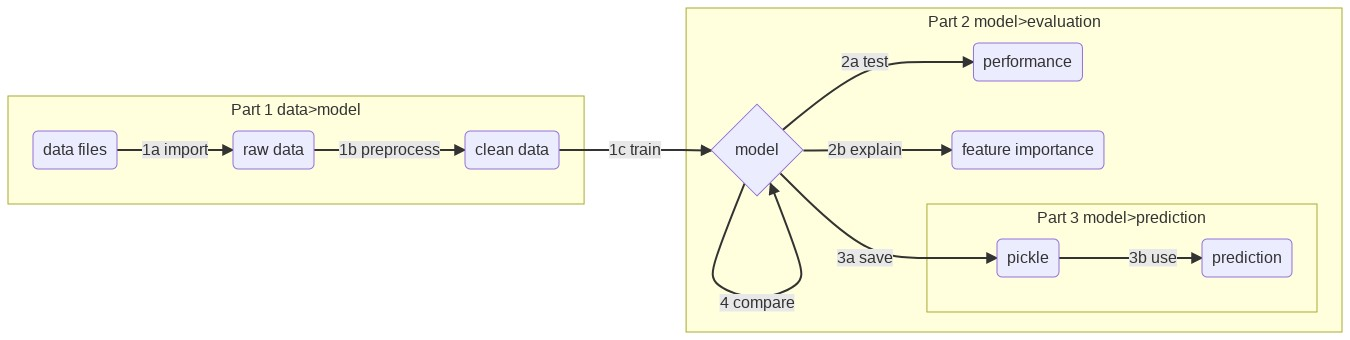


# CHOICES (Edit here only)

There are 3 choices to make: Which dataset to use, which type of random forest to run, how to run it.

Find the outcome of the code run all the way below under RUN.

In [1]:
# SETTINGS
template_id = 'tmpl00'  # options tmpl00 (default unbalanced), tmpl01 (balanced), tmpl02 (balanced + simple selection), tmpl03 (balanced + recursive selection)
dataset_id  = 'CAMR'    # options include VIBO, CAMR, BORA, for more options see options in yaml_all under Setup
how_id      = 'how2'    # how1 (single-threaded, verbose), how2 (n_jobs = 2, non-verbose)

# PIPELINE

## Setup

In [2]:
!pip install PyYAML==5.4.1
!pip install imbalanced-learn==0.8.0
!pip install scikit-learn==0.24
!pip install wget

In [3]:
from sklearn.feature_selection import SelectFromModel, RFECV
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.model_selection import train_test_split as tts
from sklearn import metrics

import yaml
from copy import deepcopy
import time
import pandas as pd
import numpy as np
import wget
import os
import bz2
import _pickle as cPickle
from itertools import chain

In [4]:
'''
Structure
                
yaml_dict['Templates']                      
yaml_dict['Options']['datasets']            
yaml_dict['Options']['featureselections']  
yaml_dict['Options']['randomforests']      
yaml_dict['Options']['Howtos']              
'''

yaml_all = """
Options:
  #Howtos:
    how1:
      how_alias: single threaded, verbose tree building
      how_id: how0
      how_name: debug
      how_skl:
        n_jobs: 1
        verbose: 1
    how2:
      how_alias: 2 threaded, non-verbose tree building
      how_id: how2
      how_name: double_threaded
      how_skl:
        n_jobs: 2
        verbose: 0
  #datasets:
    BACS:
      dataset_id: BACS
      dataset_name: Bacillus
      url: https://media.githubusercontent.com/media/e-gill/RFPlasmid2_prototype/main/contigs_csv/Bacillus_contigs.csv
    BORA:
      dataset_id: BORA
      dataset_name: Borrelia
      url: https://media.githubusercontent.com/media/e-gill/RFPlasmid2_prototype/main/contigs_csv/Borrelia_contigs.csv
    BURA:
      dataset_id: BURA
      dataset_name: Burkholderia
      url: https://media.githubusercontent.com/media/e-gill/RFPlasmid2_prototype/main/contigs_csv/Burkholderia_contigs.csv
    CAMR:
      dataset_id: CAMR
      dataset_name: Campylobacter
      url: https://media.githubusercontent.com/media/e-gill/RFPlasmid2_prototype/main/contigs_csv/Campylobacter_contigs.csv
    CLOM:
      dataset_id: CLOM
      dataset_name: Clostridium
      url: https://media.githubusercontent.com/media/e-gill/RFPlasmid2_prototype/main/contigs_csv/Clostridium_contigs.csv
    CORM:
      dataset_id: CORM
      dataset_name: Corynebacterium
      url: https://media.githubusercontent.com/media/e-gill/RFPlasmid2_prototype/main/contigs_csv/Corynebacterium_contigs.csv
    CYAE:
      dataset_id: CYAE
      dataset_name: Cyanothece
      url: https://media.githubusercontent.com/media/e-gill/RFPlasmid2_prototype/main/contigs_csv/Cyanothece_contigs.csv
    ENTE:
      dataset_id: ENTE
      dataset_name: Enterobacteriaceae
      url: https://media.githubusercontent.com/media/e-gill/RFPlasmid2_prototype/main/contigs_csv/Enterobacteriaceae_contigs.csv
    ENTS:
      dataset_id: ENTS
      dataset_name: Enterococcus
      url: https://media.githubusercontent.com/media/e-gill/RFPlasmid2_prototype/main/contigs_csv/Enterococcus_contigs.csv
    LACB:
      dataset_id: LACB
      dataset_name: Lactobacillus
      url: https://media.githubusercontent.com/media/e-gill/RFPlasmid2_prototype/main/contigs_csv/Lactobacillus_contigs.csv
    LACC:
      dataset_id: LACC
      dataset_name: Lactococcus
      url: https://media.githubusercontent.com/media/e-gill/RFPlasmid2_prototype/main/contigs_csv/Lactococcus_contigs.csv
    LISA:
      dataset_id: LISA
      dataset_name: Listeria
      url: https://media.githubusercontent.com/media/e-gill/RFPlasmid2_prototype/main/contigs_csv/Listeria_contigs.csv
    PSES:
      dataset_id: PSES
      dataset_name: Pseudomonas
      url: https://media.githubusercontent.com/media/e-gill/RFPlasmid2_prototype/main/contigs_csv/Pseudomonas_contigs.csv
    RHIM:
      dataset_id: RHIM
      dataset_name: Rhizobium
      url: https://media.githubusercontent.com/media/e-gill/RFPlasmid2_prototype/main/contigs_csv/Rhizobium_contigs.csv
    STAS:
      dataset_id: STAS
      dataset_name: Staphylococcus
      url: https://media.githubusercontent.com/media/e-gill/RFPlasmid2_prototype/main/contigs_csv/Staphylococcus_contigs.csv
    STRS:
      dataset_id: STRS
      dataset_name: Streptomyces
      url: https://media.githubusercontent.com/media/e-gill/RFPlasmid2_prototype/main/contigs_csv/Streptomyces_contigs.csv
    VIBO:
      dataset_id: VIBO
      dataset_name: Vibrio
      url: https://media.githubusercontent.com/media/e-gill/RFPlasmid2_prototype/main/contigs_csv/Vibrio_contigs.csv
  #featureselections:
    sel0:
      sel_alias: No Feature Selection
      sel_id: sel0
      sel_name: no_feature_selection
      sel_type: no_feature_selection
    sel1:
      sel_alias: Importance Based Feature Selection
      sel_id: msk1
      sel_name: sfm
    sel2:
      sel_alias: Recursive Feature Elimination with Cross Validation
      sel_id: msk4
      sel_name: rfecv
  #forests:
    rfo00:
      rfo_alias: Default - SK Scikit Learn
      rfo_id: rfo00
      rfo_name: sklearn_default
      rfo_skl:
        max_features: sqrt
        n_estimators: 100
        oob_score: true
        max_depth: 5
        random_state: 42
      rfo_type: sklearn
    rfo01:
      rfo_alias: Balanced - SK Imbalanced-Learn
      rfo_id: rfo01
      rfo_name: imblearn_default
      rfo_skl:
        max_features: sqrt
        n_estimators: 500
        oob_score: true
        max_depth: 5
        random_state: 42
        replacement: false
        sampling_strategy: not minority
      rfo_type: imblearn
Templates:
  tmpl00:
    sel_id: sel0
    rfo_id: rfo00
    template_alias: Unbalanced + Unselected
    template_id: tmpl00
    template_name: tmpl00_rfo00_sel0
    template_num: 0
  tmpl01:
    sel_id: sel0
    rfo_id: rfo01
    template_alias: Balanced + Unselected
    template_id: tmpl01
    template_name: tmpl01_rfo01_sel0
    template_num: 1
  tmpl02:
    sel_id: sel1
    rfo_id: rfo01
    template_alias: Balanced + Selected 1
    template_id: tmpl02
    template_name: tmpl02_rfo01_sel1
    template_num: 2
  tmpl03:
    sel_id: sel2
    rfo_id: rfo01
    template_alias: Balanced + Selected 2
    template_id: tmpl03
    template_name: tmpl03_rfo01_sel2
    template_num: 3
  """

yaml_dict            = yaml.load(yaml_all, Loader=yaml.FullLoader)
print(yaml_dict['Templates']['tmpl00'])

{'sel_id': 'sel0', 'rfo_id': 'rfo00', 'template_alias': 'Unbalanced + Unselected', 'template_id': 'tmpl00', 'template_name': 'tmpl00_rfo00_sel0', 'template_num': 0}


## TRAINING

In [5]:
def training(dataset_id = 'CYAE', template_id = 'tmpl00', how_id = 'how1', yaml_all = ''):
  tic = time.time()  
  
  #############################################################################
  # fetch args                                                                #
  #############################################################################
  options_dict    = deepcopy(yaml_all['Options'])
  template_dict   = deepcopy(yaml_all['Templates'][template_id])
  sel_id          = template_dict['sel_id']
  rfo_id          = template_dict['rfo_id']
  rfo_skl         = options_dict[rfo_id]['rfo_skl']
  how_skl         = options_dict[how_id]['how_skl'] 

  # model_id
  model_id = dataset_id + '_' + sel_id + '_' + rfo_id + '_' + how_id
  model_id_dict = {'model_id'          : [model_id],
                'dataset_id'      : dataset_id,
                'dataset_name'    : options_dict[dataset_id]['dataset_name'],
                'template_id'     : template_id,
                'template_alias'  : template_dict['template_alias'],
                'sel_id'          : sel_id,
                'sel_alias'       : options_dict[sel_id]['sel_alias'],
                'rfo_id'          : rfo_id,
                'rfo_alias'       : options_dict[rfo_id]['rfo_alias'],
                'rfo_type'        : options_dict[rfo_id]['rfo_type'],
                'how_id'          : how_id, 
                'how_alias'       : options_dict[how_id]['how_alias']}
  model_id_df = pd.DataFrame.from_dict(model_id_dict)

  #############################################################################
  # fetch dataset_df from contig.csv & X, y                                   #
  # input: outputcsv                                                          #
  # output: dataset_df, X, y                                                  #
  #############################################################################
  # load dataset
  url = options_dict[dataset_id]['url']
  fn  = f"{model_id_dict['dataset_name']}" + "_contigs.csv"
  if not os.path.exists(fn):
    wget.download(url, fn)
  with open(fn, 'rb') as f:
    dataset_df = pd.read_csv(f, header=0) 

  # prep y
  y = dataset_df['label']
  y = y.str.replace('p','1')
  y = y.str.replace('c','0')
  y = y.astype(int)

  # prep X  
  fea_cols = ['contig_length','SCM_genes','plasmid_genes_genes','plasmidcge_id','kmer_number','SCM','plasmid_genes']+['kmer'+str(i+1) for i in range(1024)]
  X = dataset_df[fea_cols]

  #split test/train
  X_trn, X_tst, y_trn, y_tst = tts(X, y, stratify=y,test_size=.25,random_state=42)

  #############################################################################
  # set up random forest                                                      #
  # input: rfo_type, rfo_skl, how_skl                                         #
  # output: rf_def (untrained random forest definition)                       #
  #############################################################################
  if model_id_dict['rfo_type'] == "sklearn":
    rf_def = RandomForestClassifier(**rfo_skl,**how_skl)

  if model_id_dict['rfo_type'] == "imblearn":
    IMB = round(np.maximum( sum(y)/len(y),1- sum(y)/len(y) ) *100)
    if IMB > 93 :
      rfo_skl['n_estimators'] = 1000
    if IMB > 96 :
      rfo_skl['n_estimators'] = 2000
    if IMB > 99 :
      rfo_skl['n_estimators'] = 3000
    print(f"\n{dataset_id}    using {rfo_skl['n_estimators']} trees, Imbalance is {IMB} %")
  
    rf_def = BalancedRandomForestClassifier(**rfo_skl,**how_skl)

  #############################################################################
  # Feature selection, X                                                      #
  # input: sel_type, sel_skl, X_trn, y_trn                                   #
  # output: col_names (ex ['kmer1','kmer2','kmer3'] )                         #
  #############################################################################
  print(f"\nSelecting features with:   {sel_id} & 75% of dataset")
  feats_fnl0 = len(X.columns.values)
  print(f"incoming features: {feats_fnl0}")
  threshold_sfm = "1*mean"

  ###
  # No selection
  ###
  if sel_id == 'sel0':
    threshold_sfm = "0*mean"

  ###
  # sfm
  ###
  if sel_id != 'sel2':
    rf_sel = deepcopy(rf_def)
    sfm = SelectFromModel(rf_sel, threshold = threshold_sfm).fit(X_trn,y_trn)
    sel = sfm.get_support() 
    col_names = X.columns.values[sel]
    feats_fnl1 = len(col_names)
  
  ###
  # sfm_rfecv
  ###
  if sel_id == 'sel2':
    rf_sel = deepcopy(rf_def)
    sel_skl = { 'step' : 100, 'min_features_to_select' : 1, 'cv' : 3, 'importance_getter' : "auto", 'scoring' : 'balanced_accuracy'}
  
    #Part 1
    sfm = SelectFromModel(rf_sel, threshold = threshold_sfm).fit(X_trn,y_trn)
    sel_sfm = sfm.get_support() 
    col_names_sfm = X.columns.values[sel_sfm]
    feats_fnl1 = len(col_names_sfm)

    #Part 2
    rfe = RFECV(sfm.estimator_, **sel_skl, **how_skl).fit(X_trn[col_names_sfm],y_trn)
    sel_rfe = rfe.get_support() 
    col_names_rfe = X_trn[col_names_sfm].columns.values[sel_rfe]
    col_names = col_names_rfe

  feats_fnl2 = len(col_names)
  print(f"outgoing features: {feats_fnl2}")

  #############################################################################
  # FINAL TRAINING                                                            #
  # input: X,y, col_names                                                     #
  # output: rf_fnl                                                            #
  #############################################################################
  print(f"\nTraining with all data:   100 % of data used to train")
  rf_trained = deepcopy(rf_def)
  rf_trained.fit(X[col_names], y)
  rf_trained.feature_names = list(X[col_names].columns.values)

  #############################################################################
  # EVALUATING                                                                #
  # input:  oob                                                               #
  # output: confusion matrix and some summary metrics                         #
  #############################################################################
  print("\nEvaluating the Out-of-Bag Classifications")
  y_oob = rf_trained.oob_decision_function_
  y_oob_lst = list(chain(*y_oob[:,[1]].tolist()))
  y_oob_cm = evaluating(y,y_oob_lst)

  print("Here are some metrics: ")
  print(y_oob_cm)
  #############################################################################
  # EXPLAINING                                                                #
  # input:  trained rf                                                        #
  # output: feature importances df                                            #
  #############################################################################
  print("\nExplaining Model with feature importances")
  model_ft_df = explaining(model_id,dataset_id,rf_trained)

  print("These are the top 3 most important features")
  print(model_ft_df.head(n=3))
  #############################################################################
  # Saving for later                                                          #
  # input:  rfs                                                               #
  # output: pickle                                                            #
  ############################################################################# 
  mdl_dct = {}
  mdl_dct['model_id']        = model_id
  mdl_dct['dataset_id']      = dataset_id  
  mdl_dct['rf_trained']      = rf_trained
  mdl_dct['col_names']       = col_names
 
  pkl_file = f"{model_id_dict['dataset_name']}" + "_model.pbz2"
  
  with bz2.BZ2File(pkl_file, 'w') as f:
    cPickle.dump(mdl_dct, f)

  print(f"\nThe trained model can be found in: {pkl_file}")

  toc = time.time()
  print(f"\nTotal Training Time: {round((toc - tic) / 60)} minutes")  
  return rf_trained

## EVALUATING

In [6]:
def evaluating(groundtruth, prediction_lst):
  '''
  input: ground_truth & prediction vector series or dataframe
  output: cm of format 'p_pred_p', 'p_pred_c', 'c_pred_p', 'c_pred_c' & Summary Metrics
  '''
  ###
  # cm 
  ###
  preds  = np.where(np.array(prediction_lst)>=.5, 1, 0)
  cm     = metrics.confusion_matrix(groundtruth, preds)
  cc =  cm[0,0]
  cp =  cm[0,1]
  pc =  cm[1,0]
  pp =  cm[1,1]

  TP = round(pp, ndigits=0)
  FP = round(cp, ndigits=0)
  FN = round(pc, ndigits=0)
  TN = round(cc, ndigits=0)

  cm_lst = [TP,FN,FP,TN]

  # Recall
  Recall = TP / ( TP + FN ) *100
  cm_lst.append(round(Recall, ndigits=1))
  
  # Precision
  Precision = TP / ( TP + FP ) *100
  cm_lst.append(round(Precision, ndigits=1))

  # Accuracy
  Accuracy = ( TP + TN ) / ( TP + FN + FP + TN ) *100
  cm_lst.append(round(Accuracy, ndigits=1))

  # ThreatScore
  ThreatScore = TP / ( TP + FN + FP) *100
  cm_lst.append(round(ThreatScore, ndigits=1))

  ###
  # Package
  ###
  cm_lst_nms  = ["TP"      ,"FN"      , "FP"      , "TN"      , "TruePositiveRate", "PositivePredictiveValue", "Accuracy","JaccardIndex"]
  cm_lst_nms2 = ['p_pred_p','p_pred_c', 'c_pred_p', 'c_pred_c', 'Recall', 'Precision', 'Accuracy', 'ThreatScore']
  cm_df = pd.DataFrame(np.column_stack(cm_lst),columns=cm_lst_nms2)
  
  return cm_df

## EXPLAINING

In [7]:
def explaining(model_id,dataset_id,rf):
  std = np.std([
    tree.feature_importances_ for tree in rf.estimators_], axis=0)
  feature_importances               = pd.DataFrame(list(zip(rf.feature_names,rf.feature_importances_,std)),columns =['feature_names','importances', 'std'])
  feature_importances               = feature_importances.sort_values(by='importances',ascending=False)
  feature_importances.insert( 0, 'model_id', model_id )
  feature_importances.insert( 0, 'dataset_id', dataset_id )
  
  return feature_importances

## CLASSIFYING

In [8]:
def classifying(modelpkl, dataset_url):
  tic = time.time()  
  # fetch model
  mdl_pkl     = bz2.BZ2File(modelpkl, 'rb')
  mdl_dct     = cPickle.load(mdl_pkl)
  model_id    = mdl_dct['model_id']
  dataset_id  = mdl_dct['dataset_id']      
  rf_trained  = mdl_dct['rf_trained']     
  col_names   = mdl_dct['col_names']     
  
  # load dataset
  url = dataset_url
  fn = "dataset.csv"
  dataset_nm = fn.split(".")[0]
  wget.download(url, fn)
  with open(fn, 'rb') as f:
    dataset_df = pd.read_csv(f, header=0) 
  drop_columns = ["label"]
  dataset_df.drop(drop_columns, inplace=True, axis=1,errors='ignore')

  X = dataset_df

  # feature selection
  X = X[col_names]

  # predict
  y_prd = rf_trained.predict_proba(X)

  # output prediction
  y_prd_lst   = list(chain(*y_prd[:,[1]].tolist()))
  source_lst  = X.index.tolist()
  preds_df    = pd.DataFrame(list(zip(source_lst,  y_prd_lst)),columns =['contig_id', 'y_prd'])
  preds_df.sort_values('contig_id', inplace = True)

  # to file
  fn    = 'prediction.mdl_'+modelpkl+'.dst_'+dataset_nm
  preds_df.to_csv(fn,na_rep='',index=True)

  toc = time.time()  

  #### ####       #### ####
  #### #### PRINT #### ####
  #### ####       #### ####
  print(f"Dataset:      {dataset_url}")
  print(f"size dataset: {len(dataset_df)} rows")
  print(f"Model:        {modelpkl}")
  print(f"size model:   {round(((os.stat(modelpkl).st_size)/1000000),1)} MB")
  print(f"Pred time:    {round(toc - tic)} seconds")
  print(f"Outfile:      {fn}.csv")
  return preds_df

# RUN

In [9]:
# TRAINING
rf_trained=training(dataset_id = dataset_id, template_id = template_id, how_id = how_id, yaml_all = yaml_dict)


Selecting features with:   sel0 & 75% of dataset
incoming features: 1031
outgoing features: 1031

Training with all data:   100 % of data used to train

Evaluating the Out-of-Bag Classifications
Here are some metrics: 
   p_pred_p  p_pred_c  c_pred_p  ...  Precision  Accuracy  ThreatScore
0     492.0     335.0      17.0  ...       96.7      93.5         58.3

[1 rows x 8 columns]

Explaining Model with feature importances
These are the top 3 most important features
    dataset_id              model_id  ... importances       std
6         CAMR  CAMR_sel0_rfo00_how2  ...    0.060880  0.107714
2         CAMR  CAMR_sel0_rfo00_how2  ...    0.056661  0.105388
836       CAMR  CAMR_sel0_rfo00_how2  ...    0.016886  0.053348

[3 rows x 5 columns]

The trained model can be found in: Campylobacter_model.pbz2

Total Training Time: 0 minutes


In [10]:
# CLASSIFICATION
preds_df = classifying(f"{yaml_dict['Options'][dataset_id]['dataset_name']}_model.pbz2", yaml_dict['Options'][dataset_id]["url"])

Dataset:      https://media.githubusercontent.com/media/e-gill/RFPlasmid2_prototype/main/contigs_csv/Campylobacter_contigs.csv
size dataset: 5423 rows
Model:        Campylobacter_model.pbz2
size model:   0.2 MB
Pred time:    3 seconds
Outfile:      prediction.mdl_Campylobacter_model.pbz2.dst_dataset.csv
